In [1]:
import numpy as np
import cv2
import numpy as np
import cv2
import os
import scipy.io
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import math
from sklearn.decomposition import PCA

In [2]:
np.random.seed(42)

n_components = 10

mat_files = sorted([file for file in os.listdir("data_np/") if file.endswith('.npy')])
idx = 31

image_sequence = np.load('data_np/' + mat_files[idx])
image_sequence = image_sequence[135:, :, :]
roi_coords = []

In [3]:
print(mat_files[31])

Flash_refl_50Hz_5J_-70°C_2_0002.npy


Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


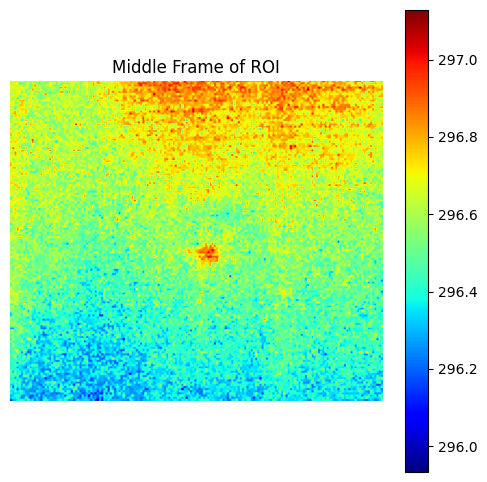

In [4]:
h, w, t = image_sequence.shape

middle_frame = image_sequence[:, :, t // 2]
frame_8bit = cv2.normalize(middle_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
colored = cv2.applyColorMap(frame_8bit, cv2.COLORMAP_JET)

roi = cv2.selectROI("Select ROI", colored, showCrosshair=True)
cv2.destroyAllWindows()

x, y, w_roi, h_roi = roi
image_sequence = image_sequence[y:y+h_roi, x:x+w_roi, :]

t = image_sequence.shape[2]
middle_frame = image_sequence[:, :, t // 2]

plt.figure(figsize=(6, 6))
plt.imshow(middle_frame, cmap='jet')
plt.title('Middle Frame of ROI')
plt.axis('off')
plt.colorbar()
plt.show()

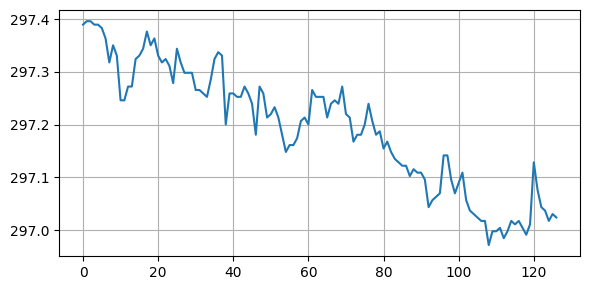

12


In [5]:
h, w, sequence_size = image_sequence.shape
plt.figure(figsize=(6, 3))
plt.plot(image_sequence.reshape(h * w, sequence_size)[5000,173:300])
plt.grid(True)
plt.tight_layout()
plt.show()

diff = np.diff(image_sequence.reshape(h * w, sequence_size)[5000,:1000])
t_pulse = np.argmax(diff)
print(t_pulse)
t_pulse = 13

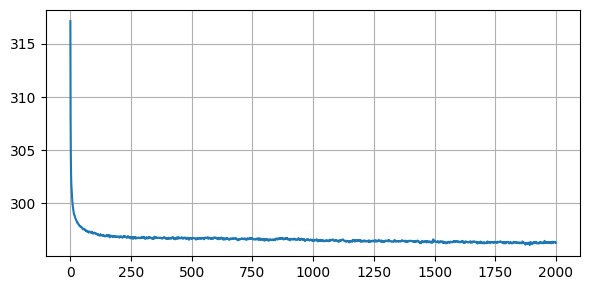

In [6]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

h, w, sequence_size = image_sequence.shape
imageMatrix = image_sequence.reshape(h * w, sequence_size)
imageMatrix = imageMatrix[:, t_pulse:]

original_len = imageMatrix.shape[1]
target_len = 2000

x_old = np.linspace(0, 1, original_len)
x_new = np.linspace(0, 1, target_len)

f = interp1d(x_old, imageMatrix, kind="linear", axis=1)
imageMatrix = f(x_new)

plt.figure(figsize=(6, 3))
plt.plot(imageMatrix[5000, :])
plt.grid(True)
plt.tight_layout()
plt.show()

imageMatrix = (imageMatrix - np.mean(imageMatrix, axis=1, keepdims=True)) #/ np.std(imageMatrix, axis=1, keepdims=True)

latent_dim = n_components

In [7]:
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(imageMatrix)

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1600):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x
    
class cnn_1d_attention(nn.Module):
    def __init__(self, latent_dim, latent_size):
        super(cnn_1d_attention, self).__init__()
        
        # Encoding
        self.enc_conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding='same')        
        self.enc_conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding='same')
        self.enc_conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding='same')
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        # Bottleneck
        self.bottleneck = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding='same')
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=128, nhead=8, dim_feedforward=512, batch_first=True),
                num_layers=4
            )

        # Decoding
        self.upsample1 = nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv1d(64, 64, kernel_size=3, stride=1, padding='same')

        self.upsample2 = nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding='same')

        self.upsample3 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv1d(16, 16, kernel_size=3, stride=1, padding='same')
        
        self.final_conv = nn.Conv1d(16, 1, kernel_size=1)
        
        # Positional Encoding
        self.positional_encoding_enc = PositionalEncoding(128)
        
        # MLP
        self.latent_len = latent_size

        self.mlp_enc = nn.Sequential(
            nn.Linear(128 * self.latent_len, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        self.mlp_dec = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.latent_len)
        )
        

    def forward(self, x):
        # Encoder
        enc1 = F.relu(self.enc_conv1(x))
        enc2 = F.relu(self.enc_conv2(self.pool(enc1)))
        enc3 = F.relu(self.enc_conv3(self.pool(enc2)))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc3))

        bottleneck_transformer = bottleneck.permute(0, 2, 1)
        bottleneck_transformer = self.positional_encoding_enc(bottleneck_transformer)

        transformer_output = self.transformer_encoder(bottleneck_transformer)
        
        z_flat = transformer_output.reshape(transformer_output.size(0), -1)
        z = self.mlp_enc(z_flat)

        transformer_recon = self.mlp_dec(z)

        z_recon = transformer_recon.view(transformer_output.size(0), transformer_output.size(1), 128)

        # Decoder
        dec1 = self.upsample1(z_recon.permute(0, 2, 1))
        dec1 = F.relu(self.dec_conv1(dec1))

        dec2 = self.upsample2(dec1)
        dec2 = F.relu(self.dec_conv2(dec2))

        dec3 = self.upsample3(dec2)
        dec3 = F.relu(self.dec_conv3(dec3))

        x_recon = self.final_conv(dec3)

        return x_recon, z, transformer_output, z_recon
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
train_data = torch.tensor(imageMatrix, dtype=torch.float32)

subset_indices = torch.randperm(train_data.shape[0])[:2500]
subset_data = train_data[subset_indices]

pca_data = pca_result[subset_indices]
z_pca_all = torch.tensor(pca_data, dtype=torch.float32, device=device)

subset_data = subset_data.unsqueeze(1).to(device)

dataset = TensorDataset(subset_data, z_pca_all)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

latent_size = imageMatrix.shape[-1] // 8
model = cnn_1d_attention(latent_dim=latent_dim, latent_size=latent_size).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [10]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for x, z_pca in dataloader:
        x = x.to(device)
        z_pca = z_pca.to(device)

        optimizer.zero_grad()
        x_recon, z_ae, z, z_recon = model(x)

        loss_recon = F.mse_loss(x_recon, x)
        loss_recon_z = F.mse_loss(z_recon, z)

        loss = loss_recon + 1.0 * loss_recon_z

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

print(f"Epoch {epoch+1}: Total Loss = {loss.item():.4f} | Recon = {loss_recon.item():.4f} | Z = {loss_recon_z.item():.4f}")

Epoch 0: Total Loss = 0.5268 | Recon = 0.4497 | Z = 0.0772
Epoch 10: Total Loss = 0.0151 | Recon = 0.0134 | Z = 0.0017
Epoch 20: Total Loss = 0.0041 | Recon = 0.0036 | Z = 0.0005
Epoch 30: Total Loss = 0.0041 | Recon = 0.0036 | Z = 0.0004
Epoch 40: Total Loss = 0.0040 | Recon = 0.0035 | Z = 0.0006
Epoch 50: Total Loss = 0.0042 | Recon = 0.0038 | Z = 0.0004
Epoch 60: Total Loss = 0.0036 | Recon = 0.0033 | Z = 0.0003
Epoch 70: Total Loss = 0.0034 | Recon = 0.0031 | Z = 0.0002
Epoch 80: Total Loss = 0.0030 | Recon = 0.0029 | Z = 0.0002
Epoch 90: Total Loss = 0.0034 | Recon = 0.0033 | Z = 0.0002
Epoch 100: Total Loss = 0.0041 | Recon = 0.0039 | Z = 0.0003


In [11]:
batch_size = 64

dataset = TensorDataset(train_data)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
all_latents = []

with torch.no_grad():
    for batch in loader:
        x = batch[0].to(device).unsqueeze(1)
        x_recon, z_ae, z, z_recon = model(x)
        all_latents.append(z_ae.cpu())
        
principal_comp = torch.cat(all_latents, dim=0).numpy()

In [12]:
pca_array = principal_comp.reshape(h, w, n_components)
pca_array = pca_array.transpose(2, 0, 1)

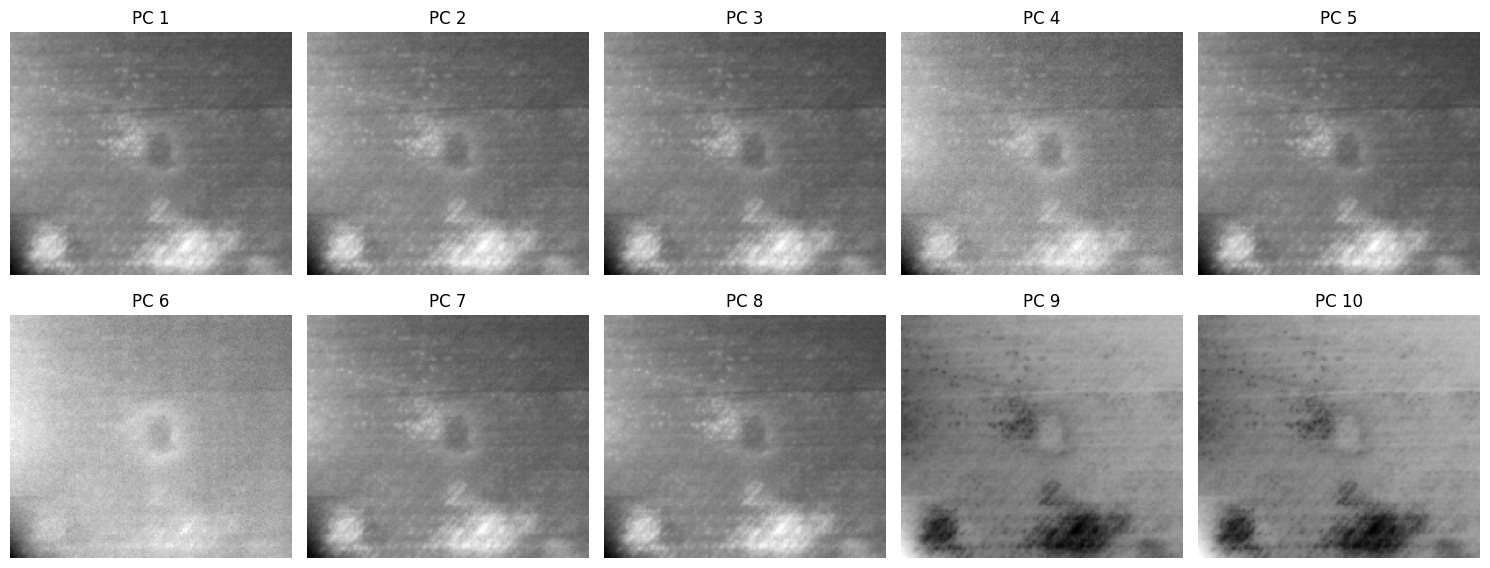

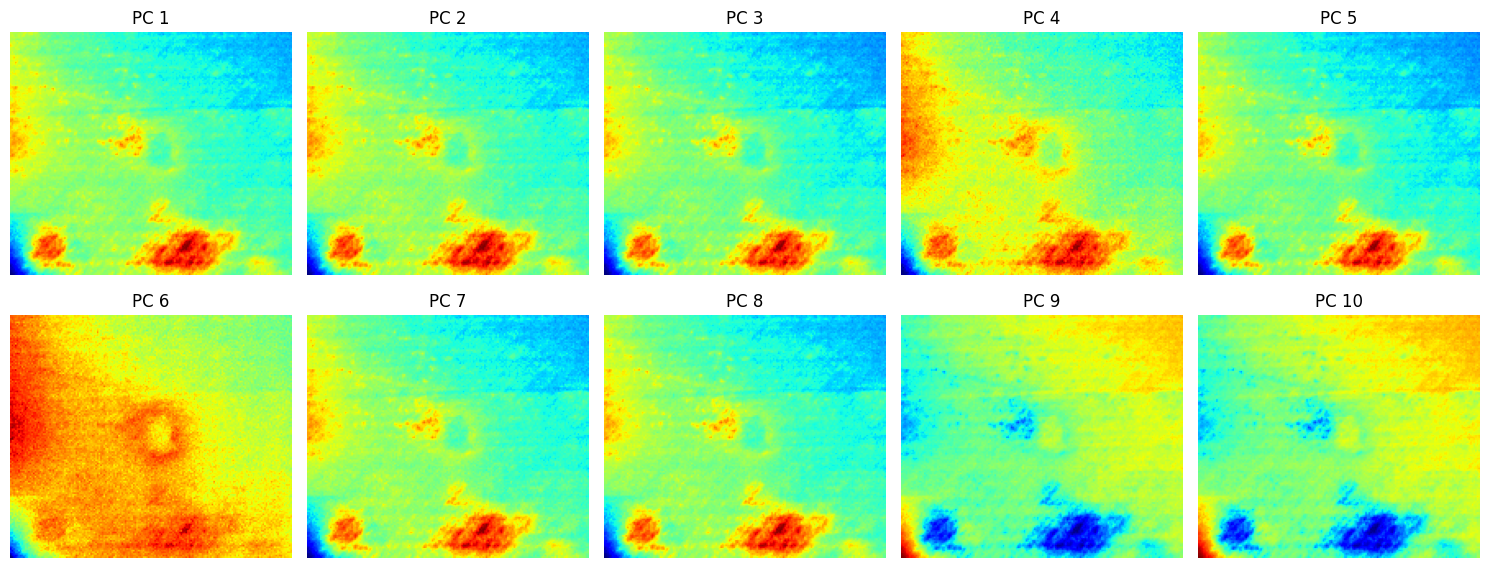

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca_array[i], cmap='jet')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

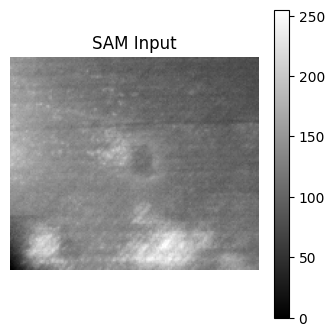

In [ ]:
# import torch
# import cv2
# import numpy as np
# import os

# comp = np.mean(pca_array, axis=0)

# comp -= comp.min()
# comp /= (comp.max() + 1e-8)
# comp = (comp * 255).astype(np.uint8)

# gray_8u = cv2.normalize(comp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
# img_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
# # img_rgb = cv2.cvtColor(gray_8u, cv2.COLOR_GRAY2RGB)

# plt.figure(figsize=(4, 4))
# plt.imshow(gray_8u, cmap='gray')
# plt.title(f'SAM Input')
# plt.axis('off')
# plt.colorbar()
# plt.show()

import numpy as np, cv2, matplotlib.pyplot as plt

eps = 1e-8
x = pca_array.astype(np.float32)

mins = x.min(axis=(1,2), keepdims=True)
maxs = x.max(axis=(1,2), keepdims=True)
den  = np.maximum(maxs - mins, eps)
x_norm = (x - mins) / den

comp = x_norm.mean(axis=0)

comp01 = (comp - comp.min()) / (comp.max() - comp.min() + eps)
gray_8u = (comp01 * 255).astype(np.uint8)

bgr = cv2.applyColorMap(gray_8u, cv2.COLORMAP_JET)
img_rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Per-channel normalized mean")
plt.show()


/home/m123/anaconda3/envs/sa2va/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/m123/anaconda3/envs/sa2va/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Loading checkpoint shards: 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


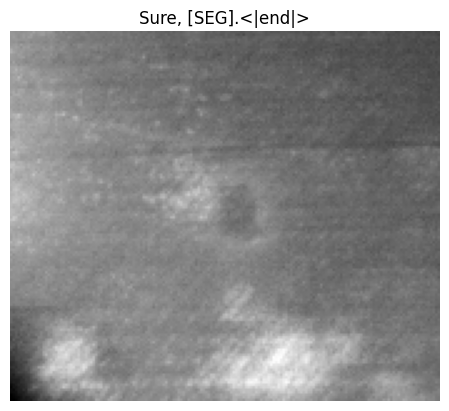

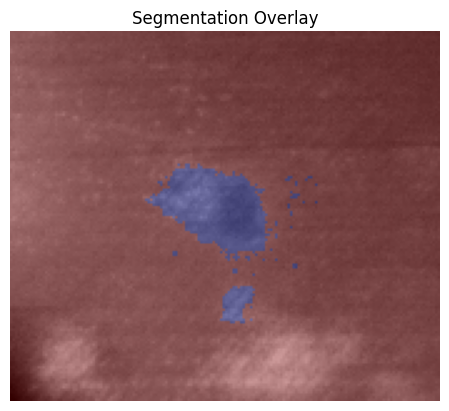

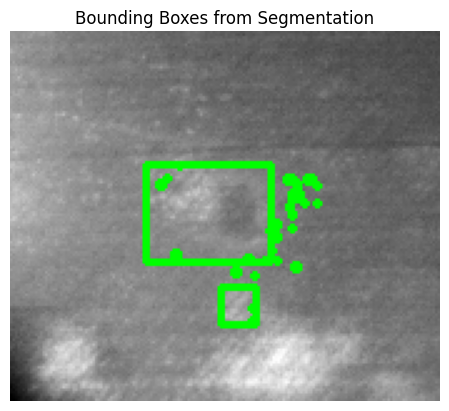

: 

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import numpy as np
import cv2

model_id = "ByteDance/Sa2VA-4B"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    use_flash_attn=True,
    low_cpu_mem_usage=True
).eval().to(device)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=False)

image = Image.fromarray(img_rgb).convert("RGB")
question = "<image> Inspect this thermal image for defects. Segment each defect and describe its type, size, and location. Return masks."

inputs = {
    "image": image,
    "text": question,
    "past_text": "",
    "mask_prompts": None,
    "tokenizer": tokenizer
}

with torch.no_grad():
    outputs = model.predict_forward(**inputs)

answer = outputs["prediction"]
masks = outputs.get("prediction_masks", None)

plt.imshow(image)
plt.title(answer)
plt.axis("off")
plt.show()

if masks and len(masks) > 0:
    mask_np = masks[0]
    if mask_np.dtype != np.uint8:
        mask_np = (mask_np * 255).clip(0, 255).astype(np.uint8)
    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze()

    mask_colored = cv2.applyColorMap(mask_np, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(image), 0.6, mask_colored, 0.4, 0)
    plt.figure()
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Segmentation Overlay")
    plt.show()

    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bbox_overlay = np.array(image).copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt) 
        cv2.rectangle(bbox_overlay, (x, y), (x + w, y + h), (0, 255, 0), 2)

    plt.figure()
    plt.imshow(bbox_overlay)
    plt.axis("off")
    plt.title("Bounding Boxes from Segmentation")
    plt.show()